In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama

from pathlib import Path
import os

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.11.0.dev148+g6d70535
scanpy      1.10.2
-----
PIL                 10.4.0
annoy               NA
asttokens           NA
cffi                1.16.0
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
executing           0.8.3
fbpca               NA
google              NA
h5py                3.11.0
igraph              0.11.6
intervaltree        NA
ipykernel           6.28.0
ipywidgets          8.1.3
jedi                0.18.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.9.1
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numpy               1.26.4
packaging           24.1
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pkg_resources       NA
platformdirs        4.2.2
prompt_to

In [3]:
directory = '/home/jing/Phd_project/project_GBM/gbm_DATA/gbm_DATA_GSE174554/gbm_DATA_scRNA_atlas'
os.chdir(directory)


In [4]:
names_list=['GSM5319518_SF2777','GSM5319548_SF2979']

In [5]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:

    mtx =f"{name}_matrix.mtx.gz"
    adata = sc.read_mtx(mtx)
    cells=pd.read_csv(f'{name}_barcodes.tsv.gz',header=None)
    features=pd.read_csv(f'{name}_features.tsv.gz',header=None,sep='\t')
    adata= adata.T
    #check the columns first to make sure they are the ones you need 
    adata.obs['CellID']= cells[0].tolist()
    adata.var['Gene']= features[0].tolist()
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata= adata[adata.obs.n_genes_by_counts <5000, :]
    adata= adata[adata.obs.pct_counts_mt< 5, :].copy()


    adata.obs['source'] = name
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)
    adata_list.append(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [6]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_912639/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [8]:
adatas = [adata_list[0],adata_list[1]]

In [13]:
adatas

[AnnData object with n_obs × n_vars = 4183 × 33694
     obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
     var: 'Gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg',
 AnnData object with n_obs × n_vars = 4277 × 33694
     obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
     var: 'Gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg']

In [10]:
adata_list[0]

AnnData object with n_obs × n_vars = 4183 × 33694
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'Gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [12]:

# Assuming adatas is a list of AnnData objects
adatas_csr = []
for ad in adatas:
    # Convert the X attribute to CSR format if it's not already in CSR format
    if not isinstance(ad.X, csr_matrix):
        ad.X = ad.X.tocsr()
    adatas_csr.append(ad)

# Now run scanorama.correct_scanpy with the CSR formatted AnnData objects
adatas_cor = scanorama.correct_scanpy(adatas_csr, return_dimred=True)


Found 33694 genes among all datasets
[[0.         0.16343231]
 [0.         0.        ]]
Processing datasets (0, 1)


In [16]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
adatas_cor[1].obsm['X_scanorama'].shape

(4277, 100)

In [46]:
batch_names = [adata.obs['source'].iloc[0] for adata in adatas_cor]


In [47]:
batch_names

['GSM5319518_SF2777', 'GSM5319548_SF2979']

In [48]:
adatas_cor_full = adatas_cor[0].concatenate(adatas_cor[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_912639/3586284196.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adatas_cor_full = adatas_cor[0].concatenate(adatas_cor[1:], batch_key='source', batch_categories=batch_names)


In [51]:
sc.pp.neighbors(adatas_cor_full, use_rep="X_scanorama")
sc.tl.umap(adatas_cor_full)
sc.tl.leiden(
    adatas_cor_full, key_added="clusters", n_iterations=2, flavor="igraph", directed=False,resolution=0.01
)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 4 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


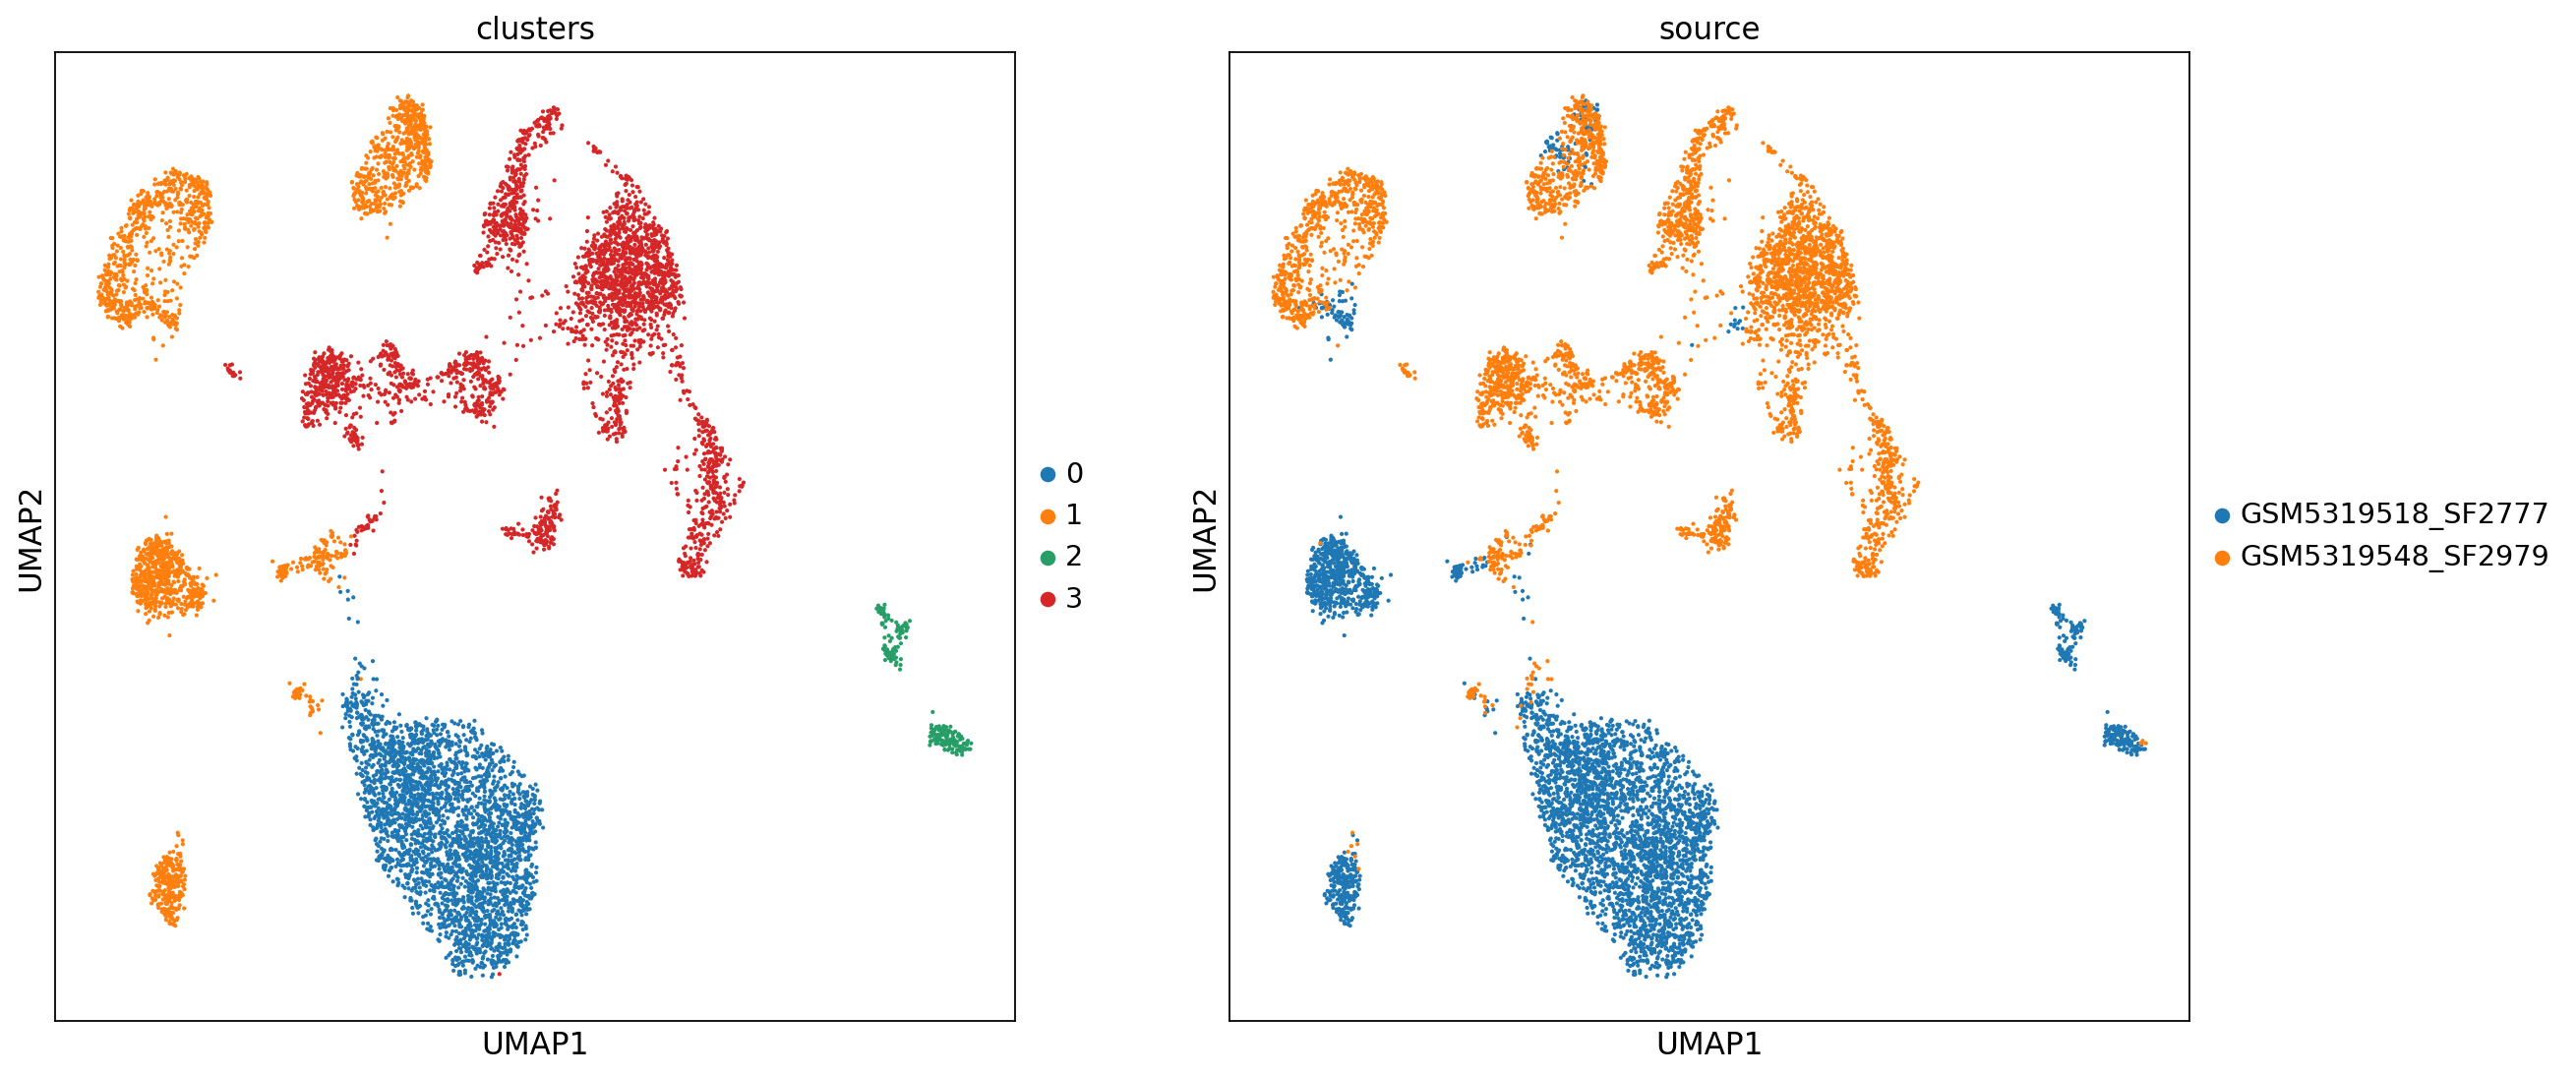

In [52]:
sc.pl.umap(
    adatas_cor_full, color=["clusters", "source"], palette=sc.pl.palettes.default_20
)